<a href="https://colab.research.google.com/github/dvirrrr/ID_Python/blob/main/Copy_of_ShoeID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libaries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix

Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Don't unzip if the data's already unziped.

In [5]:
if not os.path.exists("/content/drive/My Drive/Colab Notebooks/pictures/shoes"):
    !unzip '/content/drive/My Drive/Colab Notebooks/pictures/shoes.zip' -d '/content/drive/My Drive/Colab Notebooks/pictures/shoes'

Establish the train set

In [6]:
np.random.seed(42)

BATCH_SIZE = 32
IMG_SIZE = (240, 240)
train_set = tf.keras.utils.image_dataset_from_directory("/content/drive/My Drive/Colab Notebooks/pictures/shoes/train",
shuffle=True, validation_split=0.01, subset='training', seed=42, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1171 files belonging to 3 classes.
Using 1160 files for training.


Establish the vaildation set

In [7]:
valid_set = tf.keras.utils.image_dataset_from_directory("/content/drive/My Drive/Colab Notebooks/pictures/shoes/test",
shuffle=True, validation_split=0.2, subset='validation', batch_size=BATCH_SIZE, image_size=IMG_SIZE, seed=42)

Found 174 files belonging to 3 classes.
Using 34 files for validation.


Establish the test set

In [8]:
# test set
test_set = tf.keras.utils.image_dataset_from_directory("/content/drive/My Drive/Colab Notebooks/pictures/shoes/test", shuffle=True,
validation_split=0.2, subset='training', seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 174 files belonging to 3 classes.
Using 140 files for training.


In [9]:
# Get the cardinality (number of batches) for each set
train_set_size = train_set.cardinality().numpy()
valid_set_size = valid_set.cardinality().numpy()
test_set_size = test_set.cardinality().numpy()

# Calculate the total number of images in each set
total_train_images = train_set_size * BATCH_SIZE
total_valid_images = valid_set_size * BATCH_SIZE
total_test_images = test_set_size * BATCH_SIZE

# Print the sizes
print(f"Train set size: {total_train_images} images")
print(f"Valid set size: {total_valid_images} images")
print(f"Test set size: {total_test_images} images")

Train set size: 1184 images
Valid set size: 64 images
Test set size: 160 images


Establish the class (brand) names

In [10]:
class_names = train_set.class_names
class_names

['adidas', 'converse', 'nike']

 Display data photos with their brands


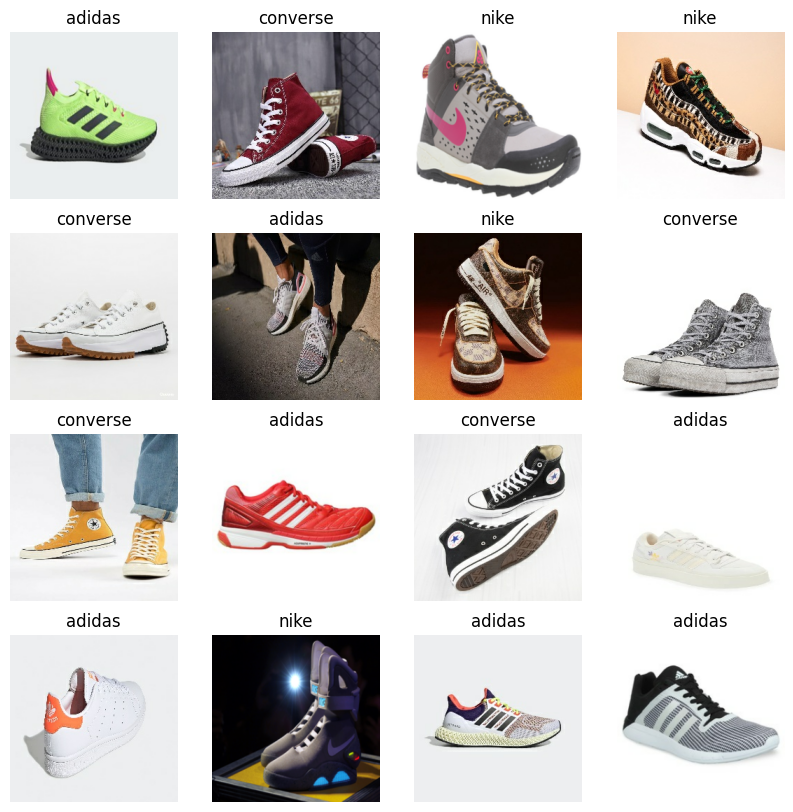

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Data augmention:

In [12]:
data_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                               tf.keras.layers.RandomRotation(0.2),
                               tf.keras.layers.RandomZoom(0.1)])

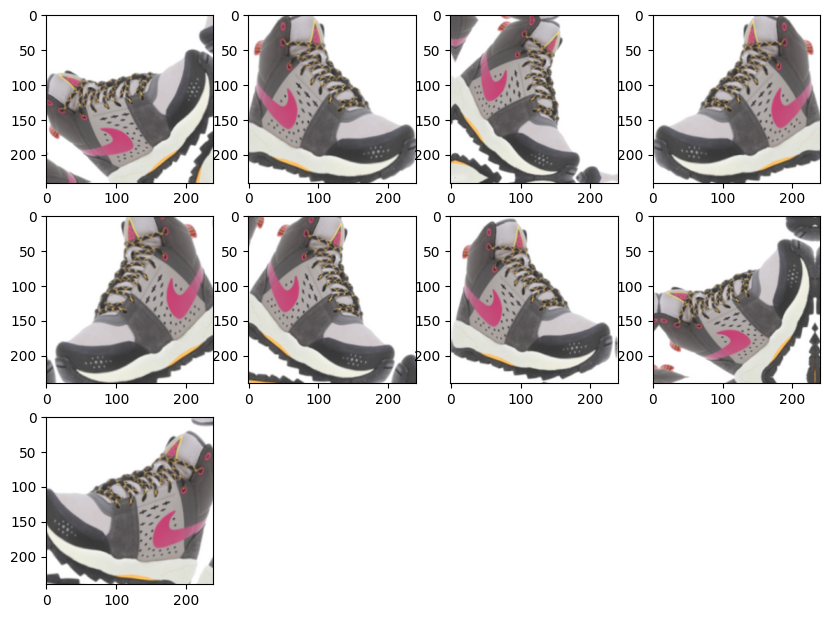

In [13]:
for image, _ in train_set.take(1):
    plt.figure(figsize=(10, 10))
    img = image[16]
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        augmented_image = data_augment(tf.expand_dims(img, 0))
        plt.imshow(augmented_image[0] / 255)

Scales the pictures' pixels for the MobileNetV2 model to work properly.


In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
  include_top=False, # removes the final layer of classification.
  weights='imagenet') # loads pre-trained weights of the MobileNetV2

<ipython-input-15-94a142d8317b>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


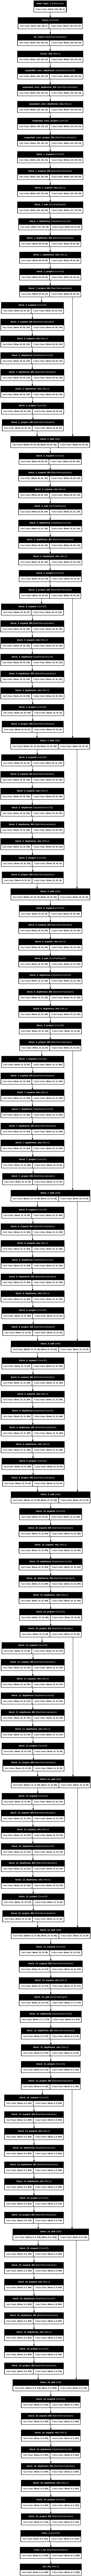

In [16]:
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
# Batch of images and labels --> base model
# Extracting the features
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 8, 8, 1280])

In [18]:
# Freezing the pre-trained weights
base_model.trainable = False


In [19]:
# Averaging the values of pixels for each image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
""" Final classification layer taking the averaged features as input and producing
predictions for each shoe brand """
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [21]:
# inputs with shape argument
inputs = tf.keras.Input(shape=(240, 240, 3))

# Data Augmentation
x = data_augment(inputs)

# Preprocessing (Normalizing) the data
x = preprocess_input(x)

# Freezing the layers
x = base_model(x, training=False)

# Global average pooling to reduce dimensions
x = global_average_layer(x)

# Dropout layer to reduce overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Output layer
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [22]:
# compiling the model, specifying the optimizer, loss function, and metrics to be used during training.
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

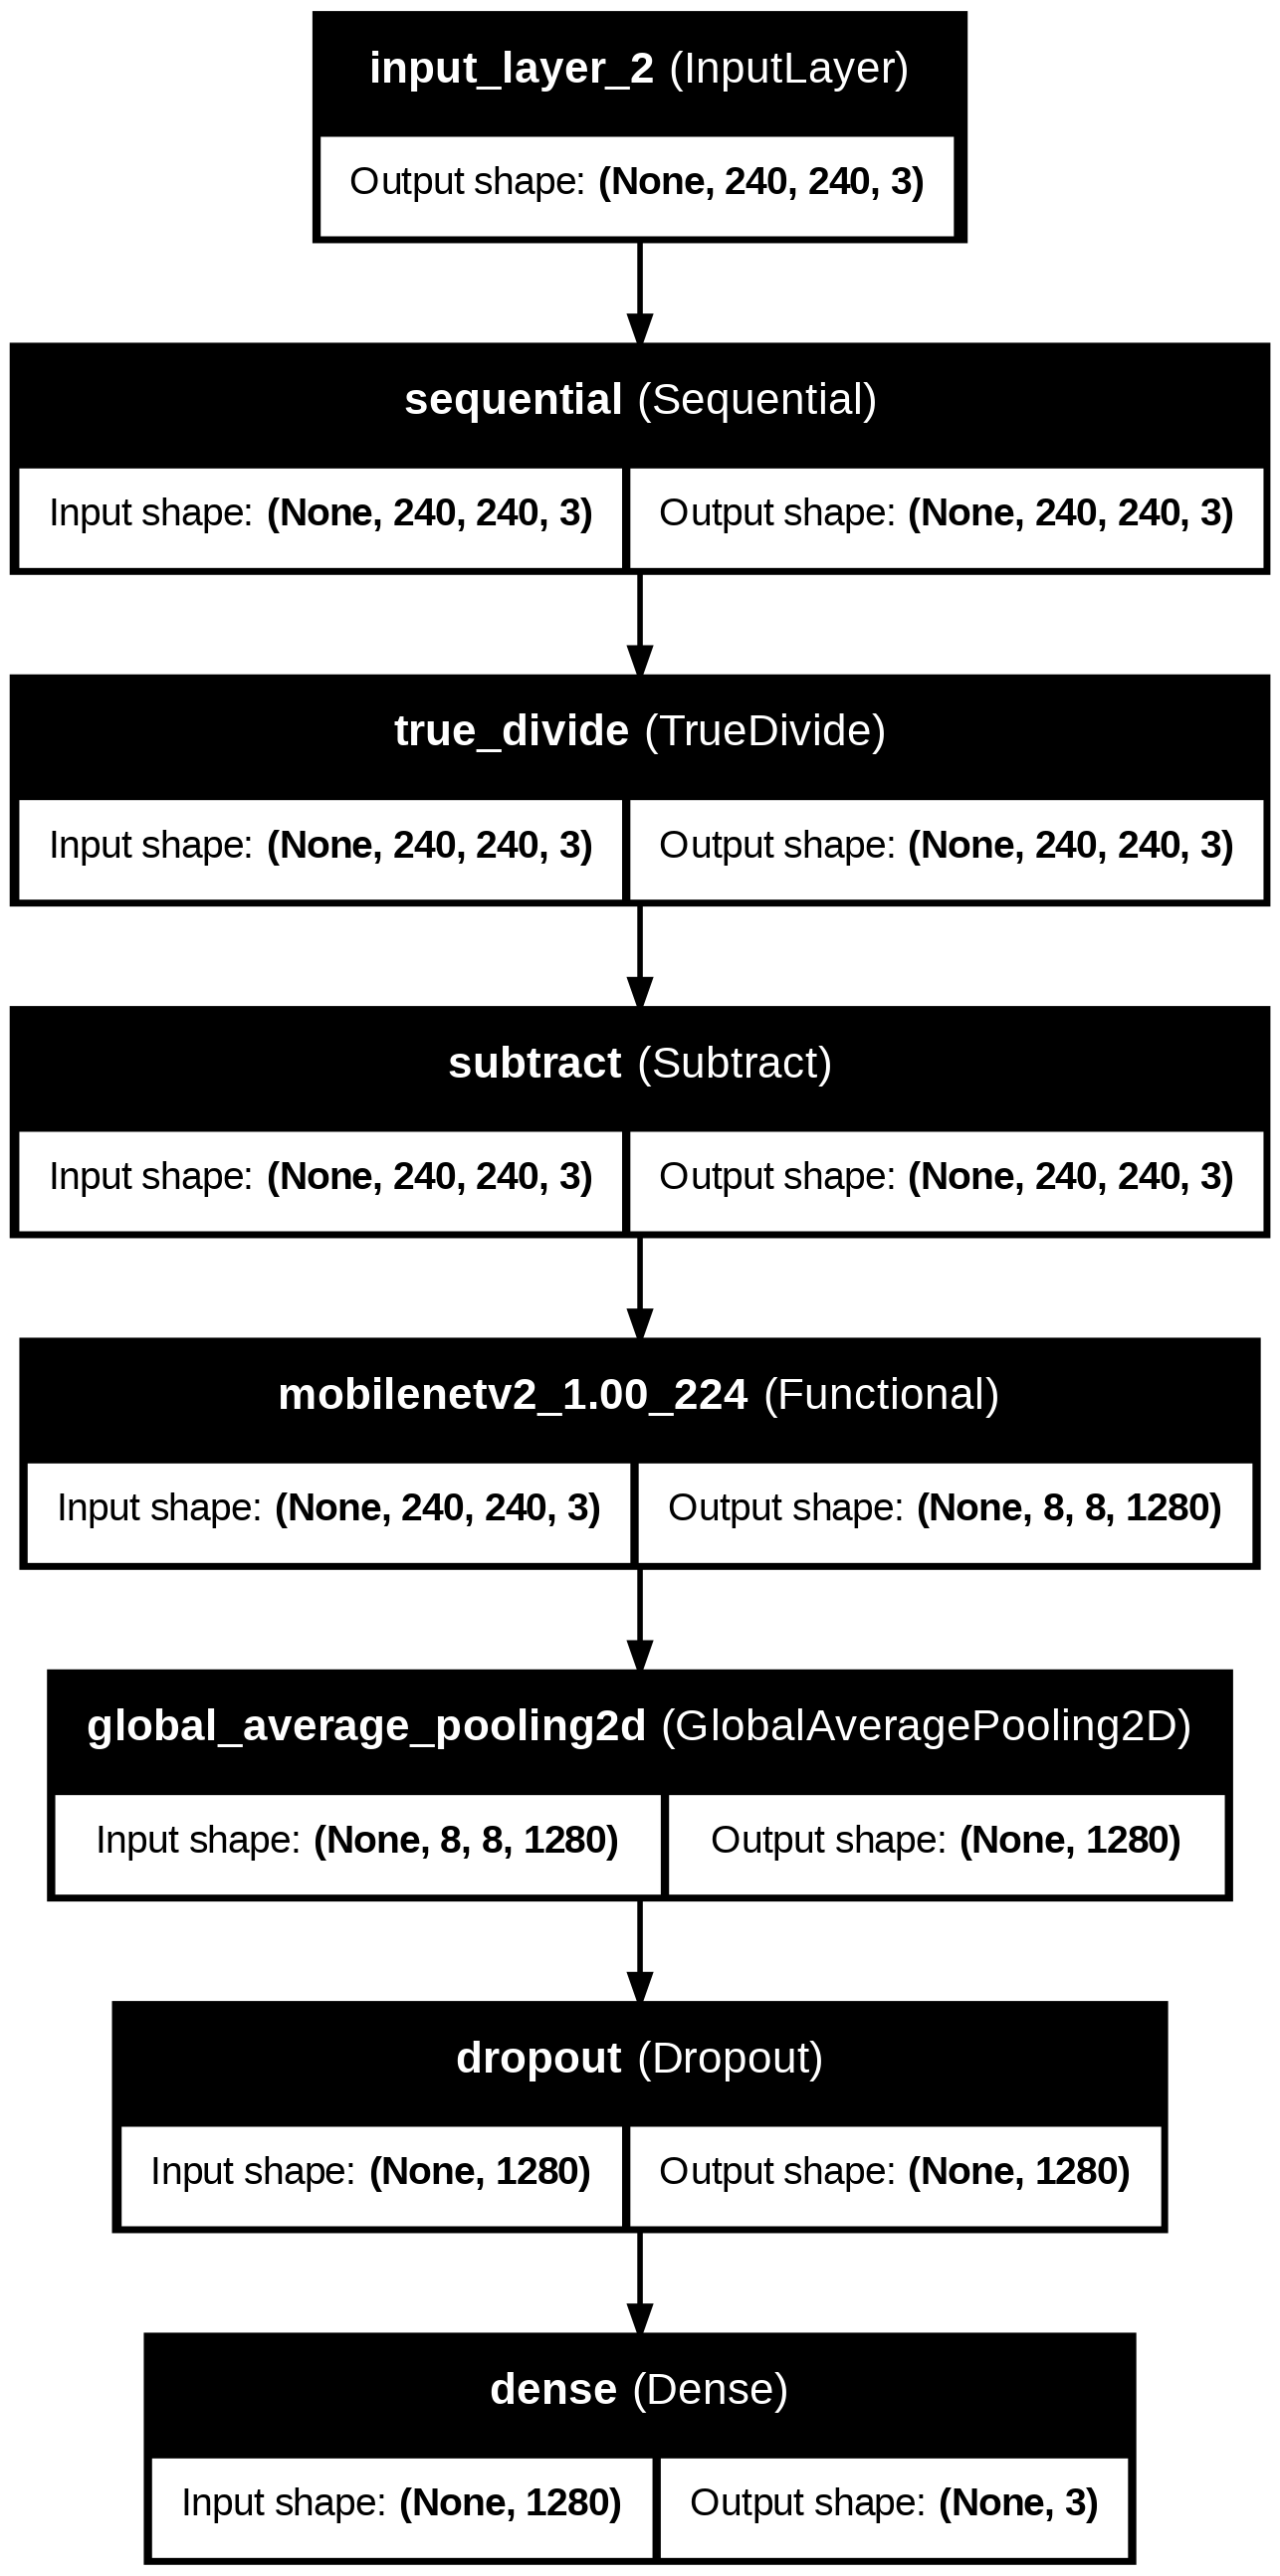

In [23]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_set)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3002 - loss: 1.5846


In [25]:
history = model.fit(train_set,
                    epochs=initial_epochs,
                    validation_data=valid_set)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 411ms/step - accuracy: 0.3671 - loss: 1.3309 - val_accuracy: 0.4118 - val_loss: 1.1375
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5102 - loss: 0.9841 - val_accuracy: 0.5000 - val_loss: 1.0160
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5641 - loss: 0.9196 - val_accuracy: 0.5588 - val_loss: 0.9241
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6471 - loss: 0.7958 - val_accuracy: 0.6765 - val_loss: 0.8548
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6758 - loss: 0.7427 - val_accuracy: 0.6765 - val_loss: 0.8169
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6814 - loss: 0.7129 - val_accuracy: 0.7353 - val_loss: 0.7998
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7142 - loss: 0.6769 - val_accuracy: 0.7353 - val_loss: 0.7872
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7335 - loss: 0.6436 - val_accuracy: 0.7353 -

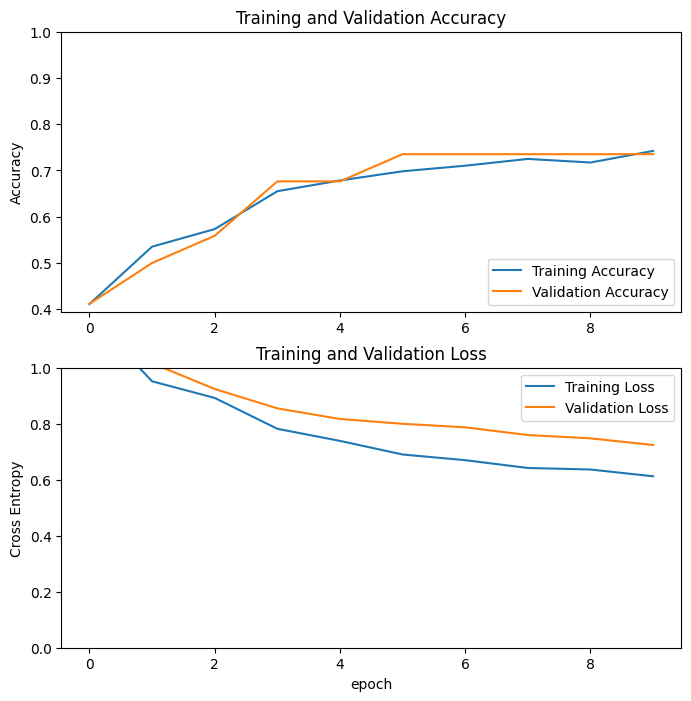

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
# Unfreezing the layers
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

## Freezing the initial 100 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

Number of layers in the base model:  154


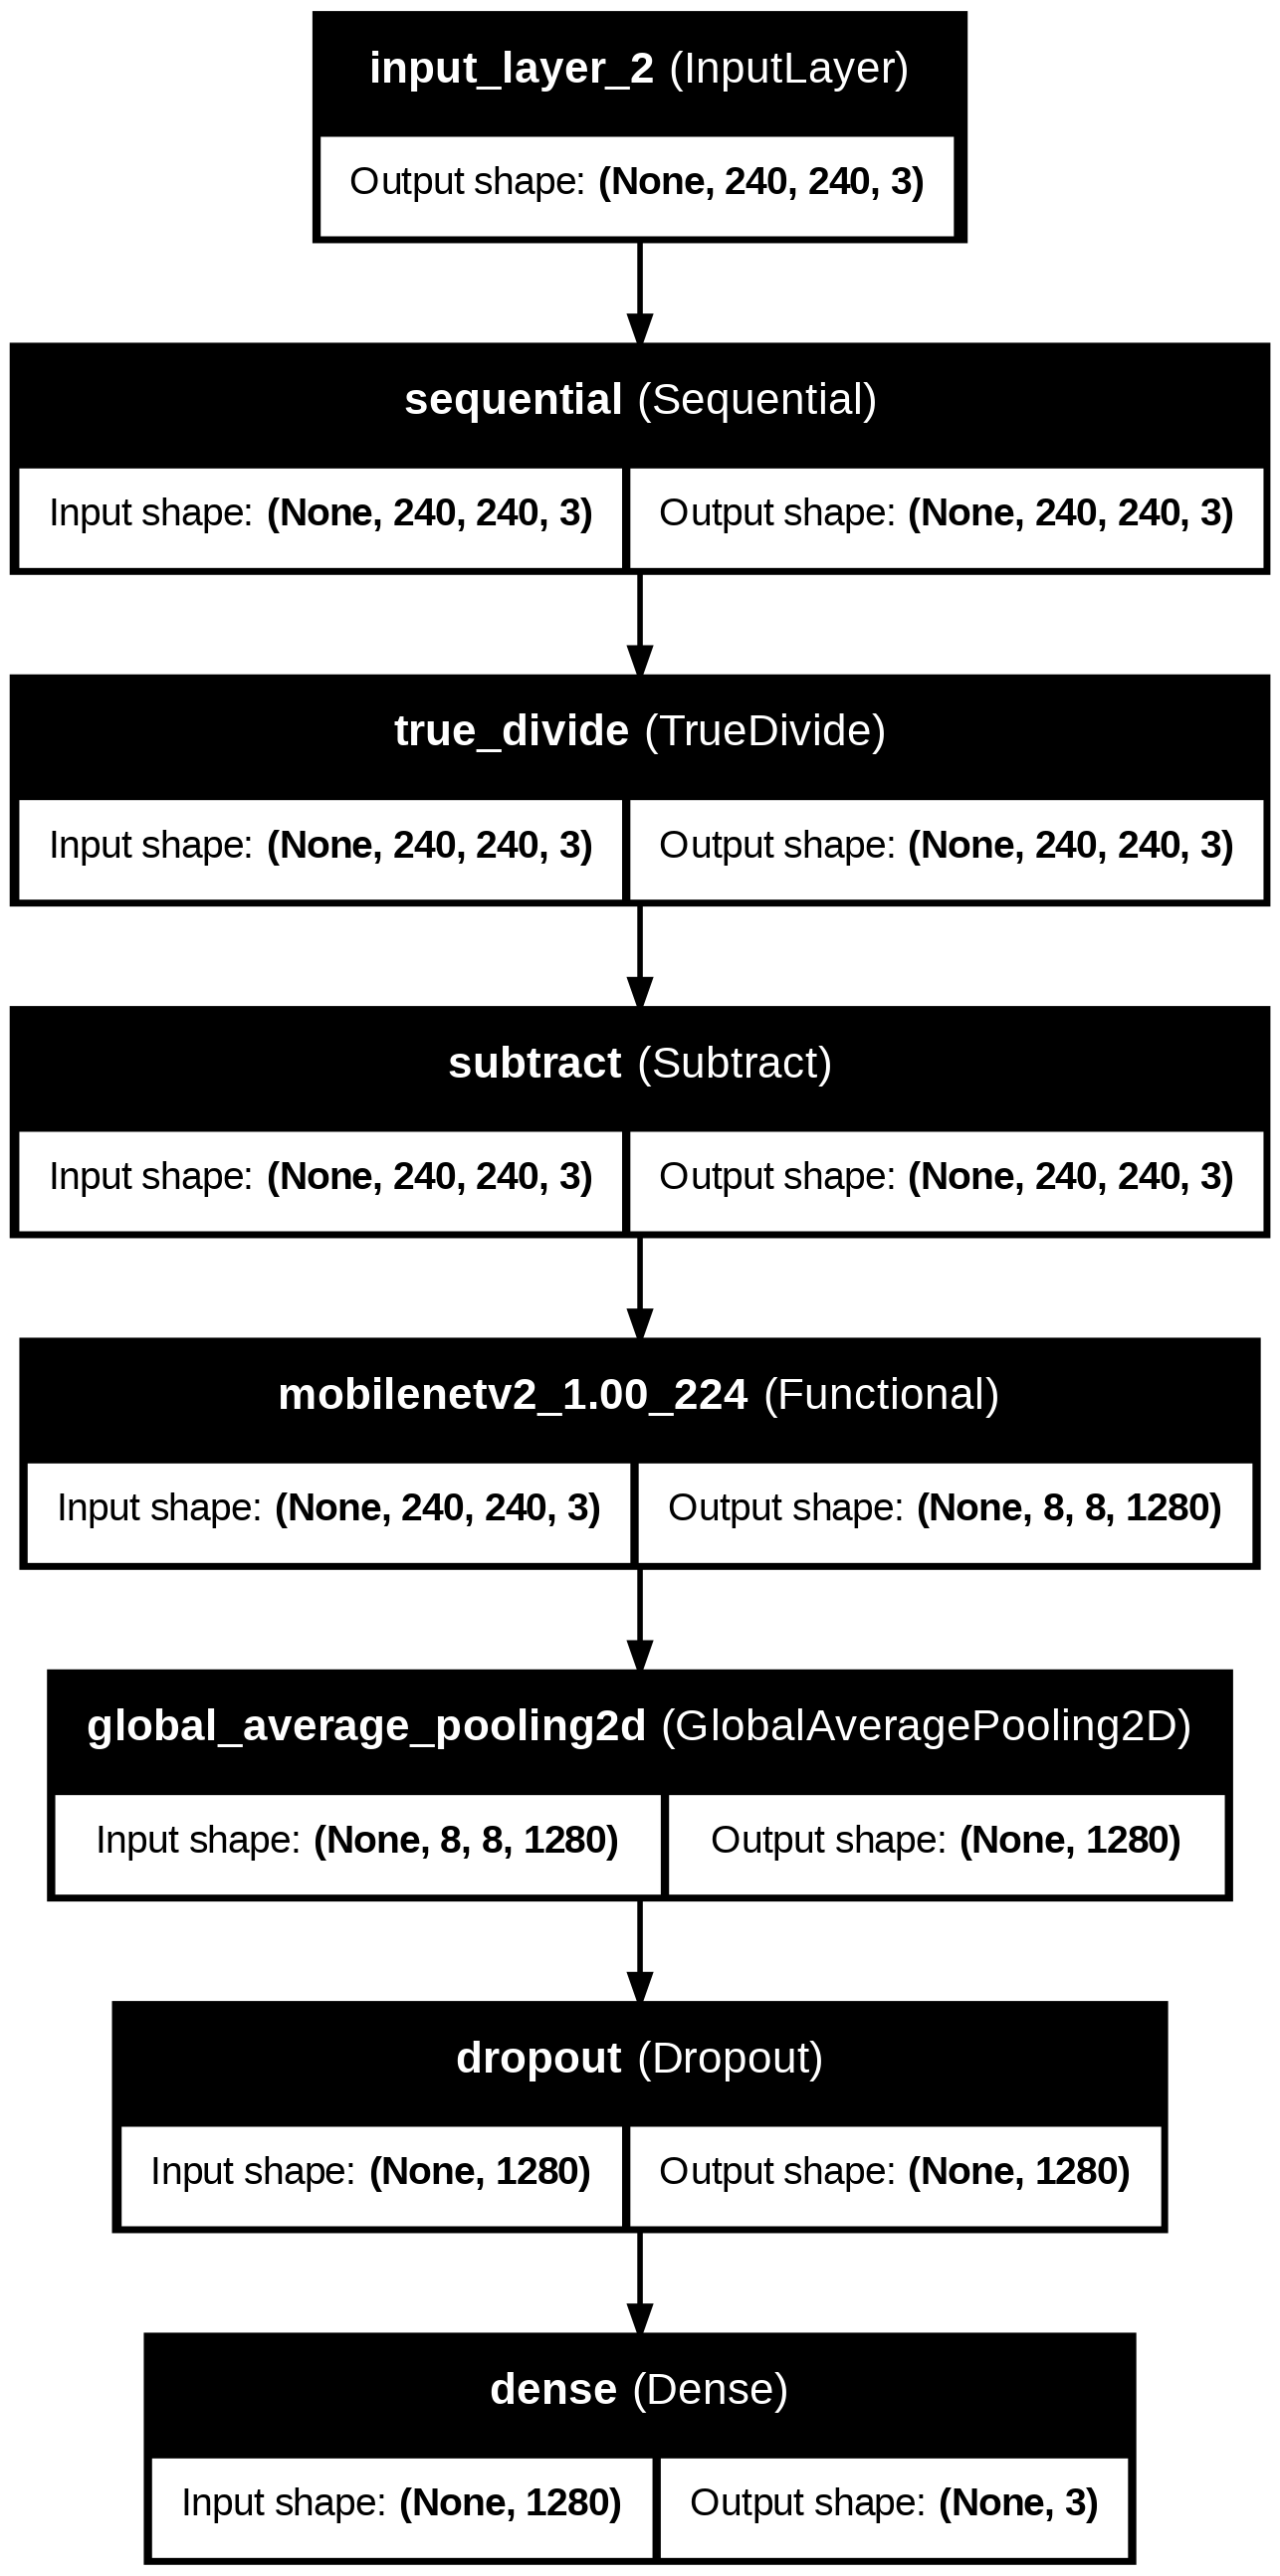

In [28]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
checkpoint_filepath = '/content/drive/MyDrive/best_model.keras' # Choose a path to save the model

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy', # Monitor validation accuracy
    mode='max', # Save the model with the highest validation accuracy
    save_best_only=True # Only save the best model
)

In [30]:
fine_tune_epochs = 45
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_set,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_set,
    callbacks=[model_checkpoint_callback] # Add the callback here
)

Epoch 10/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.6841 - loss: 0.6955 - val_accuracy: 0.7353 - val_loss: 0.7392
Epoch 11/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7992 - loss: 0.4893 - val_accuracy: 0.7647 - val_loss: 0.7434
Epoch 12/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8425 - loss: 0.3943 - val_accuracy: 0.7647 - val_loss: 0.7174
Epoch 13/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8721 - loss: 0.3271 - val_accuracy: 0.6471 - val_loss: 0.9637
Epoch 14/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8897 - loss: 0.2892 - val_accuracy: 0.7059 - val_loss: 0.8706
Epoch 15/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9284 - loss: 0.2119 - val_accuracy: 0.7353 - val_loss: 0.8145
Epoch 16/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9326 - loss: 0.1821 - val_accuracy: 0.7353 - val_loss: 0.8570
Epoch 17/55
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9412 - loss: 0.1644 - val_accuracy: 

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

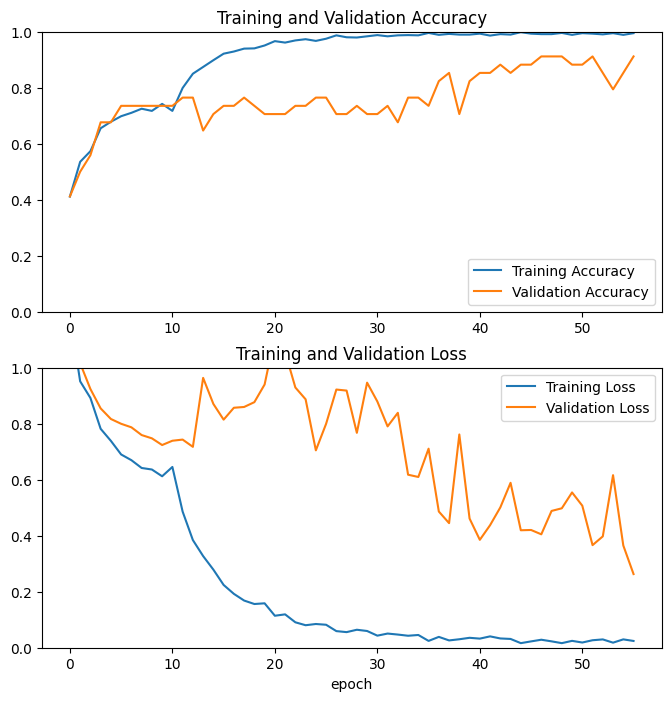

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
print("We got an accuracy of {:.2f}%".format(model.evaluate(test_set)[1]*100))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - accuracy: 0.8577 - loss: 0.4971
We got an accuracy of 88.57%


In [34]:
# Initialize lists to store all predictions and true labels
all_predictions = []
all_labels = []

# Iterate through all batches in the test set
for image_batch, label_batch in test_set.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.nn.softmax(predictions)
    predicted_labels = np.argmax(predictions, axis=1)  # Get predicted labels for the batch

    all_predictions.extend(predicted_labels)  # Add predictions to the list
    all_labels.extend(label_batch)  # Add true labels to the list


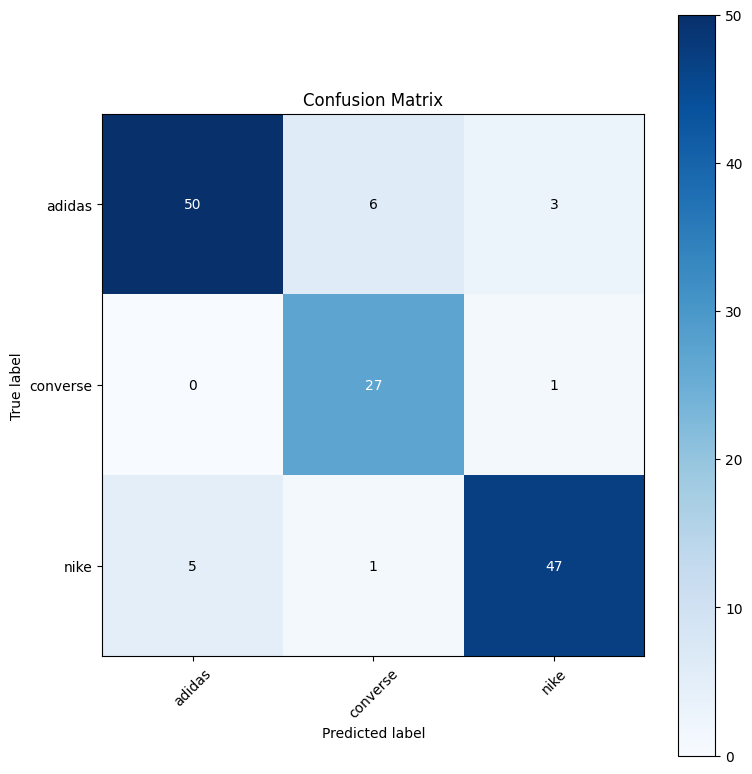

In [40]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create heatmap table with numbers using plt
plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Display as image with colormap
plt.title("Confusion Matrix")
plt.colorbar()  # Add colorbar

# Add numbers as text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Set tick labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


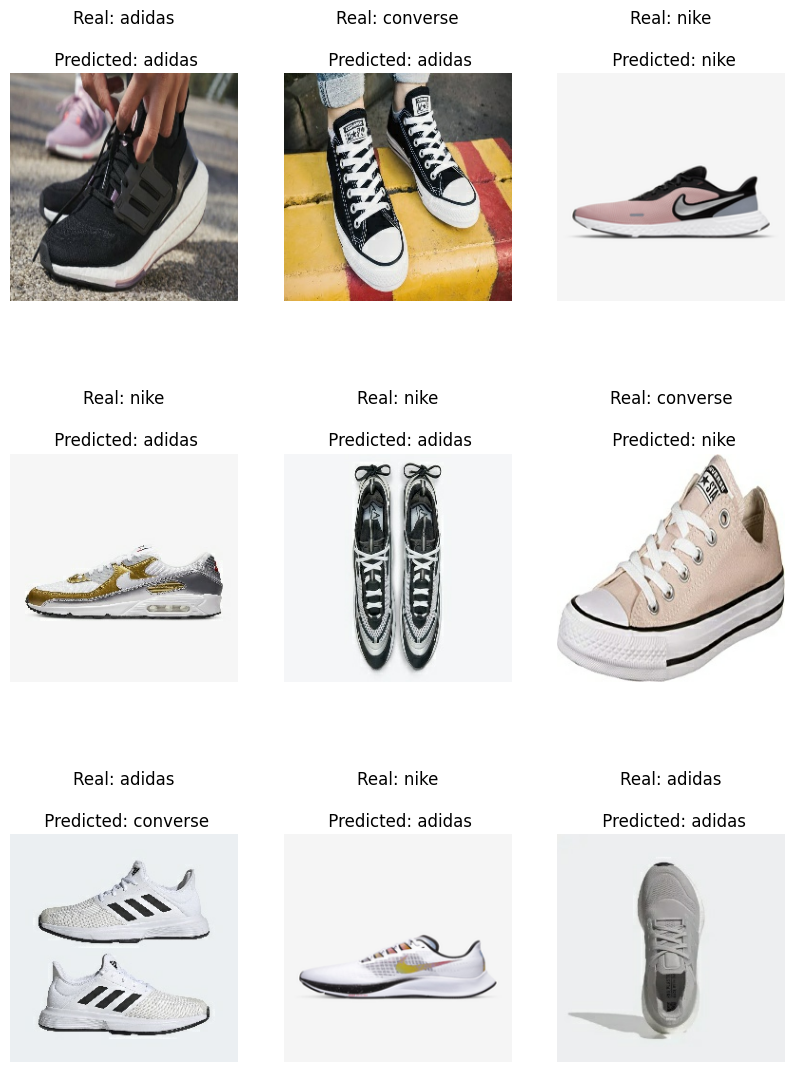

In [39]:
plt.figure(figsize=(10, 14))
for i in range(min(9, len(image_batch))):  # Ensure we don't go beyond image_batch size
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))

    # Use all_predictions instead of y_pred
    plt.title(f"Real: {class_names[label_batch[i]]}\n\n Predicted: {class_names[all_predictions[i]]}")

    plt.axis("off")